In [25]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.double)
import scipy.stats as stats
from itertools import product
import matplotlib.pyplot as plt
import pickle
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [26]:
def get_hsic_test_power(results, null):
    q = np.quantile(null, 0.95)
    
    return (results > q).sum()/len(results)

In [27]:
def get_corr_test_power(results):
    a = 0
    
    for res in results:
        a += (res[1] > 0.975) | (res[1] < 0.025)
    
    return a/len(results)

In [61]:
LOAD = [
    #'mmd_vs_path_scaling_2022-02-21_19.50.38.731424.pickle',
    #'mmd_vs_path_scaling_2022-02-21_20.26.07.009560.pickle',
    #'mmd_vs_path_scaling_2022-02-21_21.14.48.789427.pickle'
    'pickles/hsic_gaussian_eval.pickle'
]

In [62]:
results = []

for path in LOAD:
    with open(path, 'rb') as f:
        results.append(pickle.load(f))

In [63]:
for i, result in enumerate(results):
    print()
    print('NEW RES', i)
    print()
    
    pp.pprint(result)


NEW RES 0

{   'A': 0.2,
    'COMMENT': 'Using the V_statistic now, faster and also seems reliable',
    'COV RESULTS': {   0.8: [   (tensor(-0.0143), 0.6843193812019681),
                                (tensor(0.0237), 0.21211053013423442),
                                (tensor(0.0332), 0.13140236300723074),
                                (tensor(6.2296e-05), 0.4991988066445927),
                                (tensor(-0.0121), 0.6524937915668025),
                                (tensor(0.0111), 0.3556742167565139),
                                (tensor(0.0020), 0.47409369728552864),
                                (tensor(-0.0372), 0.893824006489681),
                                (tensor(-0.0205), 0.7432498589020573),
                                (tensor(0.0703), 0.008883144447755953),
                                (tensor(0.0005), 0.4934650016553316),
                                (tensor(-0.0083), 0.6066225784336718),
                                (tensor(-0.02

In [143]:
results_15_samples = results[0][1] #0.3 only is interesting
results_6_samples = results[1][0] #0 - 0.4
results_2_samples = results[0][3] #0.3 only

In [152]:
pp.pprint(results_6_samples)

{   'COMMENT': 'Using the V_statistic now, faster and also seems reliable',
    'COV RESULTS': {   0: [   (tensor(-0.0222), 0.5637762016029908),
                              (tensor(-0.1464), 0.8555494894912712),
                              (tensor(0.0224), 0.42310667416729053),
                              (tensor(-0.0653), 0.6785299932816475),
                              (tensor(-0.2495), 0.9441534752214008),
                              (tensor(-0.2307), 0.9580212389119143),
                              (tensor(-0.0068), 0.5185675384514798),
                              (tensor(-0.1428), 0.8732500765961182),
                              (tensor(-0.1064), 0.7436313912901735),
                              (tensor(-0.0056), 0.5173030759383901),
                              (tensor(0.0981), 0.2287774081873668),
                              (tensor(0.0454), 0.36386043976343263),
                              (tensor(-0.0448), 0.6065079247111943),
                            

In [172]:
corr_powers = []
hsic_powers = []
corr = results_6_samples['COVS'][1:]
print(corr)
for cov in corr:
    corr_powers.append(get_corr_test_power(results_6_samples['COV RESULTS'][cov]))
    hsic_powers.append(get_hsic_test_power(results_6_samples['TEST DISTS'][cov], results_6_samples['NULL']))

[0.05, 0.1, 0.2, 0.3, 0.4]


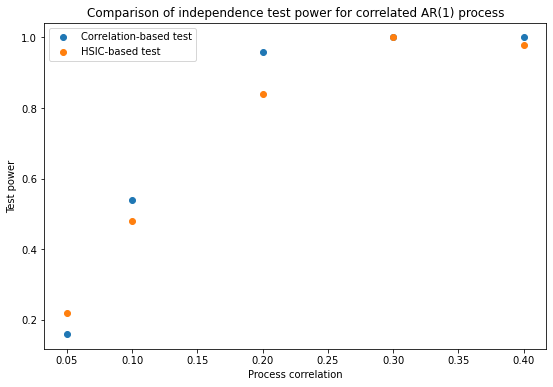

In [179]:
plt.figure(figsize = (9, 6))
plt.title('Comparison of independence test power for correlated AR(1) process')
plt.scatter(corr, corr_powers, label = 'Correlation-based test')
plt.scatter(corr, hsic_powers, label = 'HSIC-based test')
plt.ylabel('Test power')
plt.xlabel('Process correlation')
plt.legend()
#plt.savefig('./pics/corr_vs_hisc_test_on_correlated_ar_1.png')

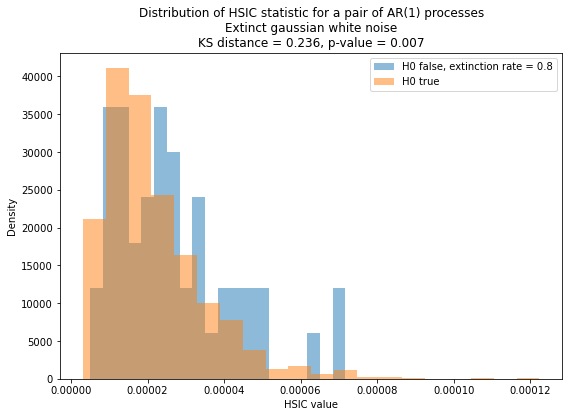

In [66]:
res = stats.ks_2samp(result['TEST DISTS'][0.8], result['NULL'])
plt.figure(figsize = (9, 6))
plt.title("Distribution of HSIC statistic for a pair of AR(1) processes\nExtinct gaussian white noise\nKS distance = {:.3f}, p-value = {:.3f}".format(res.statistic, res.pvalue))
plt.hist(result['TEST DISTS'][0.8], bins = 20, alpha = 0.5, label = 'H0 false, extinction rate = 0.8', density = True);
plt.hist(result['NULL'], bins = 20, alpha = 0.5, label = 'H0 true', density = True);
plt.xlabel('HSIC value')
plt.ylabel('Density')
plt.legend()
plt.savefig('./pics/hsic_extinct_gaussian_eval.png')

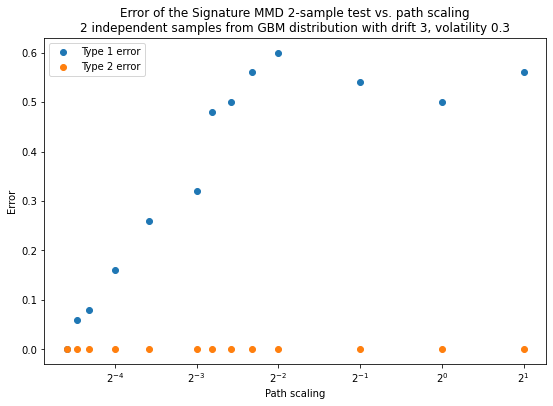

In [52]:
plt.figure(figsize = (9, 6))
plt.scatter(1/np.array(sorted(result.keys())), [np.array(result[DIV]['same']).sum()/50 for DIV in sorted(result.keys())], label = 'Type 1 error')
plt.scatter(1/np.array(sorted(result.keys())), [1 - np.array(result[DIV]['different']).sum()/50 for DIV in sorted(result.keys())], label = 'Type 2 error')
plt.title("Error of the Signature MMD 2-sample test vs. path scaling\n2 independent samples from GBM distribution with drift 3, volatility 0.3")
plt.xlabel('Path scaling')
plt.ylabel('Error')
plt.xscale('log', base = 2)
plt.legend()
plt.savefig('./pics/mmd_2sample_error_vs_path_scaling.png')

In [42]:
main_result = {
    'RESULTS' : result,
    'GBM_1_PARAMS' : { 'd' : 3, 'v' : 0.3 },
    'GBM_2_PARAMS' : { 'd' : 1, 'v' : 3 },
}

In [43]:
with open('./pickles/mmd_2sample_test_path_scaling_sweep.pickle', 'wb') as f:
    pickle.dump(main_result, f)